In [1]:
import pathlib

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib as mpl

from typing import Tuple, List, Dict, Any, Callable, Union

In [2]:
PATH_DATA = pathlib.Path("/kaggle/input/") / "rose-eval-2019"
PATH_TRAINING = PATH_DATA / "training"
PATH_TEST = PATH_DATA / "test"

PATH_WORKING = pathlib.Path("/kaggle/working")

# defines the images' paths
PATHS_TRAINING_IMAGES = [
    *list(PATH_TRAINING.glob("*/*/Images/*.jpg")),
    *list(PATH_TRAINING.glob("*/*/Images/*.png"))
]

# retieves the corresponding masks' paths
PATHS_TRAINING_MASKS = [f.parents[1] / "Masks" / (f.stem + ".png") for f in PATHS_TRAINING_IMAGES]

# retrieves test images
PATHS_TEST = [
    *list(PATH_TEST.rglob("*.jpg")),
    *list(PATH_TEST.rglob("*.png"))
]

In [3]:
mpl.rcParams['image.cmap'] = 'gray'
def show(*args):
    s = 10
    _, axs = plt.subplots(1, len(args), figsize=(s*len(args),s*1.6))
    
    for i in range(len(args)):
        axs[i].imshow(args[i])
        #plt.xticks([]), plt.yticks([])
    plt.show()

## The idea

In [4]:
image = cv.imread(PATHS_TRAINING_IMAGES[0].as_posix(), cv.IMREAD_COLOR)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

mask_raw = cv.imread(PATHS_TRAINING_MASKS[0].as_posix(), cv.IMREAD_COLOR)
mask_raw = cv.cvtColor(mask_raw, cv.COLOR_BGR2RGB)
mask = (
    np.all(mask_raw==[255,255,255],axis=2)[:,:,np.newaxis] + 
    np.all(mask_raw==[216, 67, 82],axis=2)[:,:,np.newaxis]
).astype(np.float).squeeze()

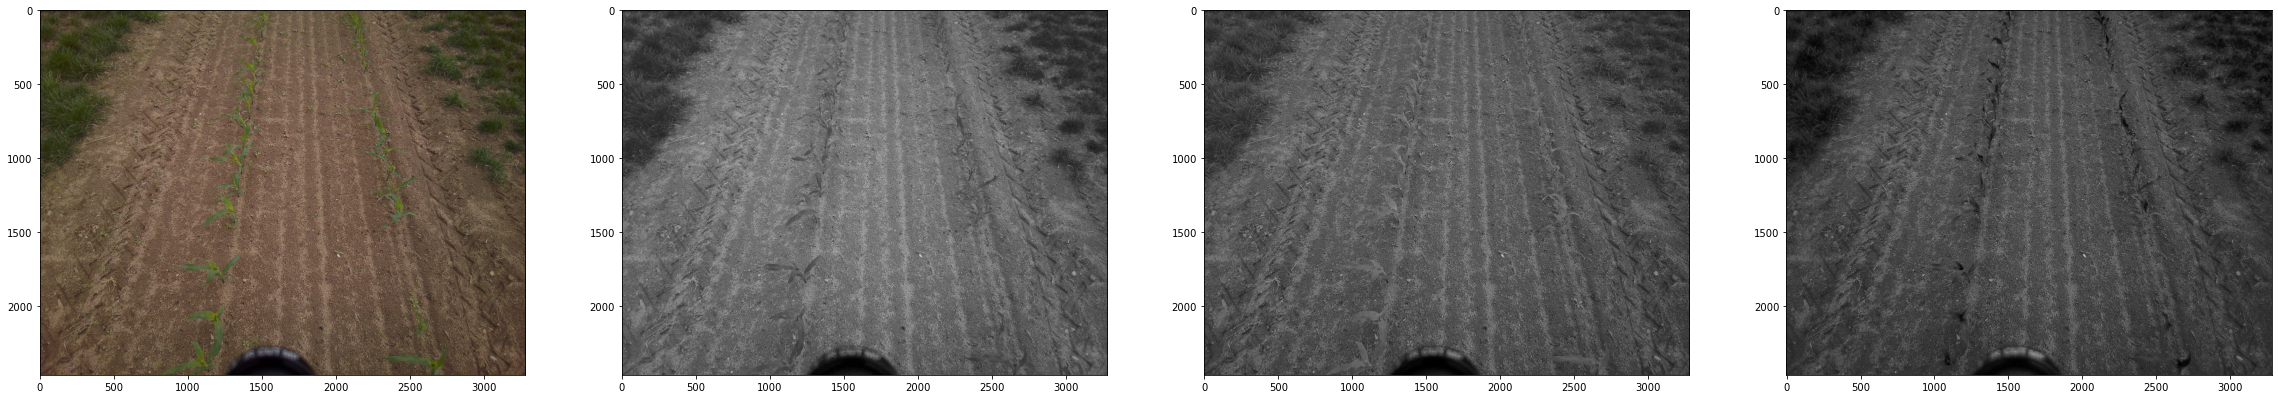

In [5]:
show(image, image[:,:,0], image[:,:,1], image[:,:,2])

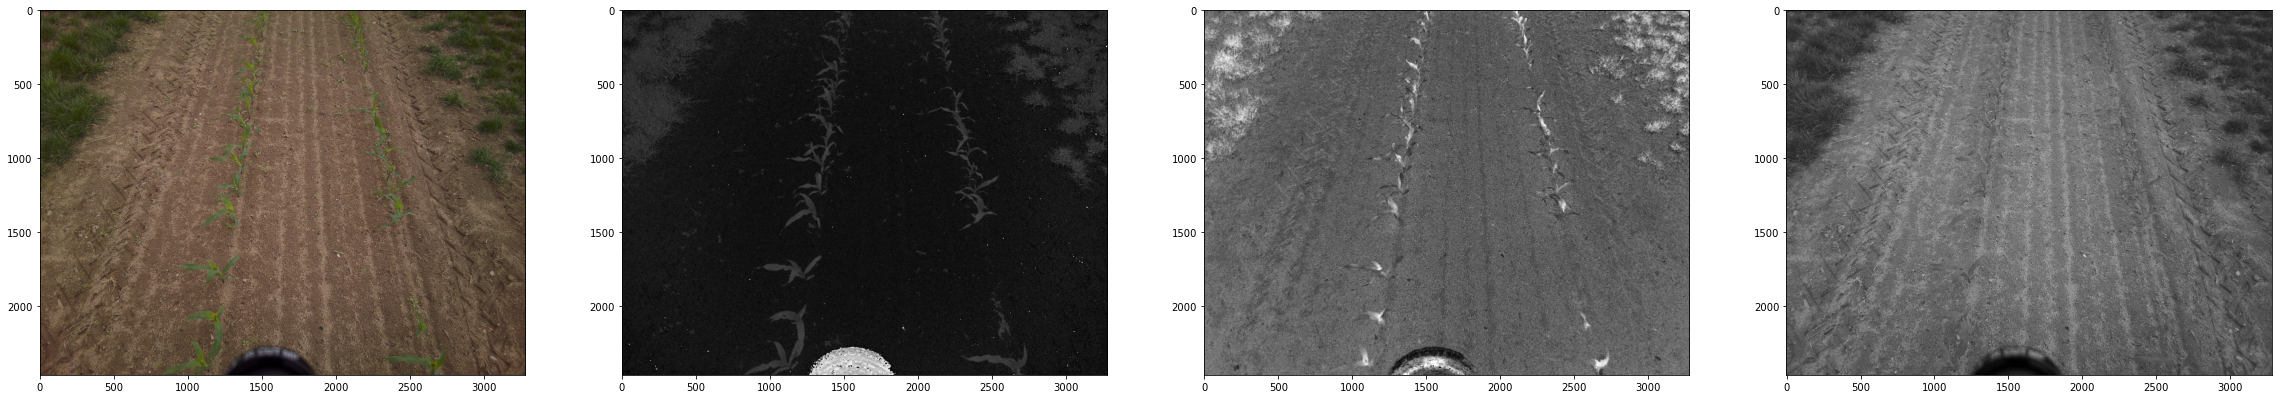

In [6]:
image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
show(image, image_hsv[:,:,0], image_hsv[:,:,1], image_hsv[:,:,2])

### The simplest mask colors based

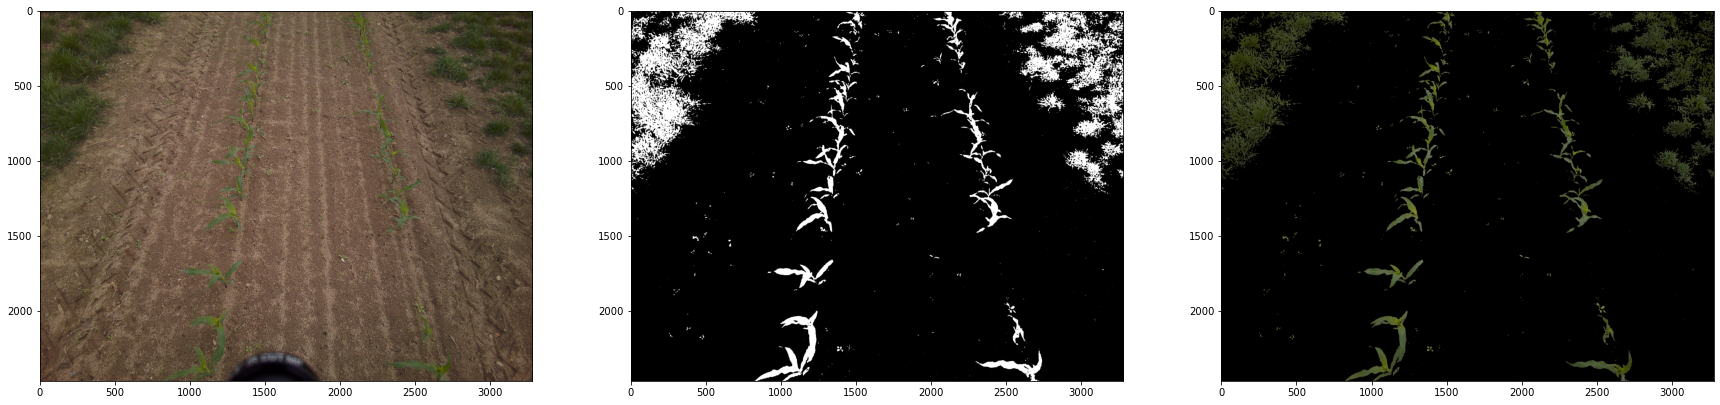

In [7]:
simple_mask = cv.inRange(image_hsv, (30, 30, 0), (60, 255, 230))
image_masked = cv.bitwise_and(image, image, mask = simple_mask)
show(image, simple_mask, image_masked)

### An approach to the boundaries researching

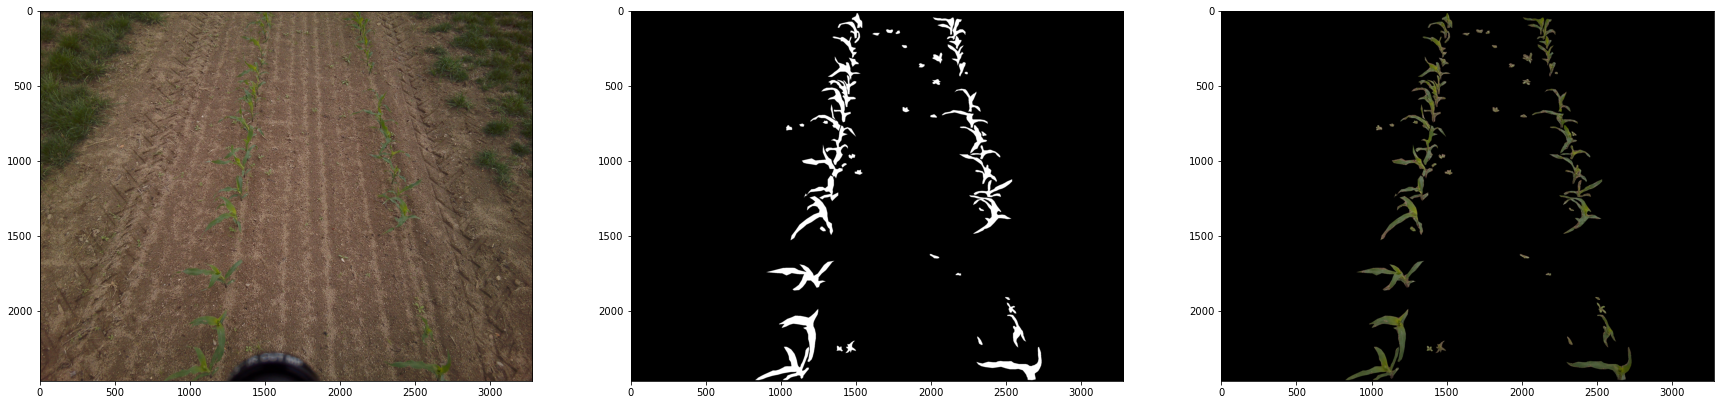

In [8]:
mask = cv.imread(PATHS_TRAINING_MASKS[0].as_posix(), cv.IMREAD_COLOR)
mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
mask = (
    np.all(mask==[255,255,255],axis=2)[:,:,np.newaxis] + 
    np.all(mask==[216, 67, 82],axis=2)[:,:,np.newaxis]
).astype(np.uint8).squeeze() * 255

image_masked = cv.bitwise_and(image, image, mask=mask)

show(image, mask, image_masked)

In [9]:
def get_histogram(image, mask=None) -> np.array:
    return np.concatenate([
            cv.calcHist([image],[0],mask,[256],[0,256]),
            cv.calcHist([image],[1],mask,[256],[0,256]),
            cv.calcHist([image],[2],mask,[256],[0,256])
        ],axis=1)

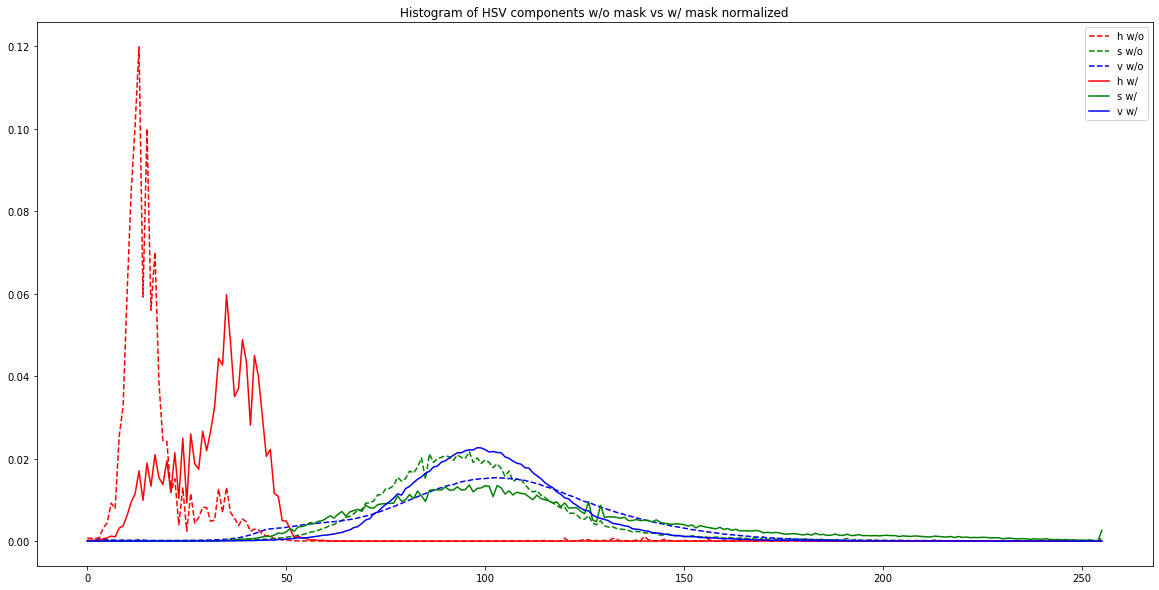

In [10]:
histogram_hsv = get_histogram(image_hsv)
histogram_hsv_masked = get_histogram(image_hsv, mask)

histogram_hsv_normalized = histogram_hsv / sum(histogram_hsv)
histogram_hsv_masked_normalized = histogram_hsv_masked / sum(histogram_hsv_masked)

plt.figure(figsize=(20,10))
plt.plot(histogram_hsv_normalized[:,0], "r", histogram_hsv_normalized[:,1],"g", histogram_hsv_normalized[:,2],"b", linestyle='dashed')
plt.plot(histogram_hsv_masked_normalized[:,0], "r", histogram_hsv_masked_normalized[:,1],"g", histogram_hsv_masked_normalized[:,2],"b")
plt.legend(["h w/o","s w/o","v w/o", "h w/", "s w/", "v w/"])
_ = plt.title("Histogram of HSV components w/o mask vs w/ mask normalized")

### Compute histogram from serveral pictures

In [11]:
histogram_hsv_dataset = np.zeros((256, 3), dtype=np.float)
histogram_hsv_dataset_masked = np.zeros((256, 3), dtype=np.float)

for i in range(len(PATHS_TRAINING_IMAGES)):
    current_image = cv.imread(PATHS_TRAINING_IMAGES[i].as_posix(), cv.IMREAD_COLOR)
    current_image = cv.cvtColor(current_image, cv.COLOR_BGR2HSV)
    
    current_mask = cv.imread(PATHS_TRAINING_MASKS[i].as_posix(), cv.IMREAD_COLOR)
    current_mask = cv.cvtColor(current_mask, cv.COLOR_BGR2RGB)
    current_mask = (
        np.all(current_mask==[255,255,255],axis=2)[:,:,np.newaxis] + 
        np.all(current_mask==[216, 67, 82],axis=2)[:,:,np.newaxis]
    ).astype(np.uint8).squeeze() * 255
    
    histogram_hsv_dataset += get_histogram(current_image)
    histogram_hsv_dataset_masked += get_histogram(current_image, current_mask)

In [12]:
histogram_hsv_dataset_normalized = histogram_hsv_dataset / sum(histogram_hsv_dataset)
histogram_hsv_dataset_masked_normalized = histogram_hsv_dataset_masked / sum(histogram_hsv_dataset_masked)

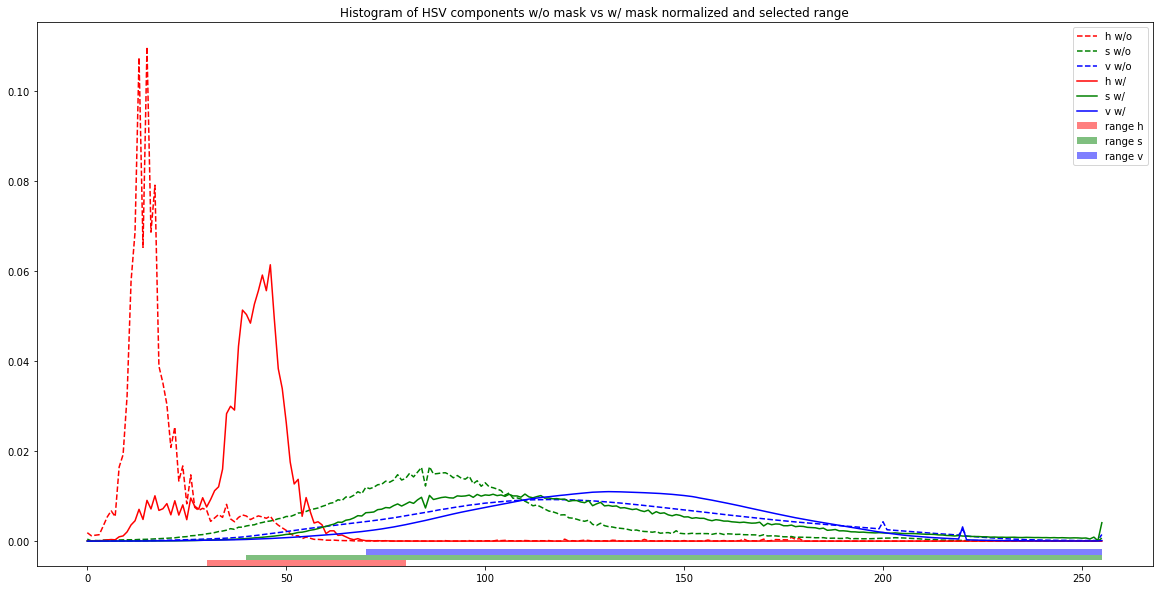

In [13]:
plt.figure(figsize=(20,10))
plt.plot(
    histogram_hsv_dataset_normalized[:,0], "r",
    histogram_hsv_dataset_normalized[:,1], "g",
    histogram_hsv_dataset_normalized[:,2], "b",
    linestyle='dashed')
plt.plot(histogram_hsv_dataset_masked_normalized[:,0], "r",
         histogram_hsv_dataset_masked_normalized[:,1], "g",
         histogram_hsv_dataset_masked_normalized[:,2], "b")

plt.axvspan(30, 80, 0, 0.01, facecolor="r", alpha=0.5)
plt.axvspan(40, 255, 0.01, 0.02, facecolor="g", alpha=0.5)
plt.axvspan(70, 255, 0.02, 0.03, facecolor="b", alpha=0.5)

plt.legend(["h w/o","s w/o","v w/o", "h w/", "s w/", "v w/", "range h", "range s", "range v"])

_ = plt.title("Histogram of HSV components w/o mask vs w/ mask normalized and selected range")

### Mask creation

In [14]:
MASK_LIMITS_HSV = ((30,40,70), (80,255,255))

In [15]:
image = cv.imread(PATHS_TRAINING_IMAGES[100].as_posix(), cv.IMREAD_COLOR)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)

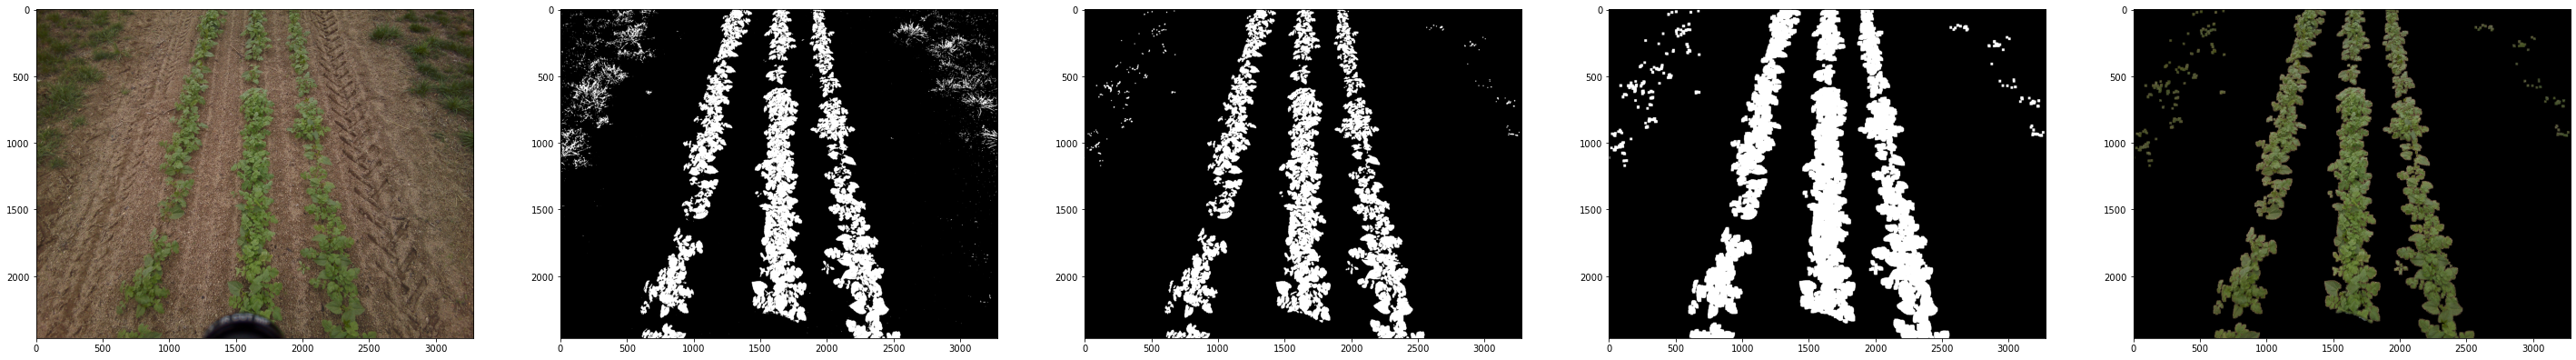

In [16]:
designed_mask = cv.inRange(image_hsv, *MASK_LIMITS_HSV)

denoised_mask = cv.morphologyEx(designed_mask, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT, (7,7)))

dilatated_mask = cv.dilate(denoised_mask, np.ones((5,5),np.uint8), iterations = 3)

image_masked = cv.bitwise_and(image, image, mask = dilatated_mask)

show(image, designed_mask, denoised_mask, dilatated_mask, image_masked)

## The mask function

In [17]:
def mask_image(image: np.array):
    image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)

    designed_mask = cv.inRange(image_hsv, *MASK_LIMITS_HSV)

    denoised_mask = cv.morphologyEx(designed_mask, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT, (7,7)))

    dilatated_mask = cv.dilate(denoised_mask, np.ones((5,5),np.uint8), iterations = 3)

    image_masked = cv.bitwise_and(image, image, mask = dilatated_mask)

    return image_masked

### The final test

A comparison between real image, computed mask and real mask

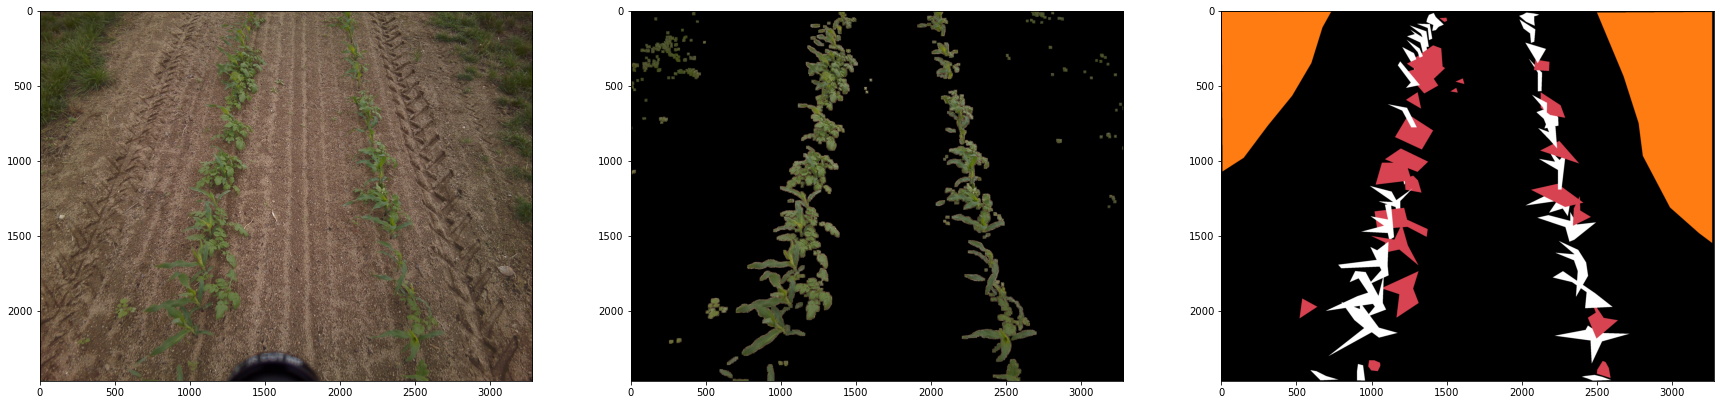

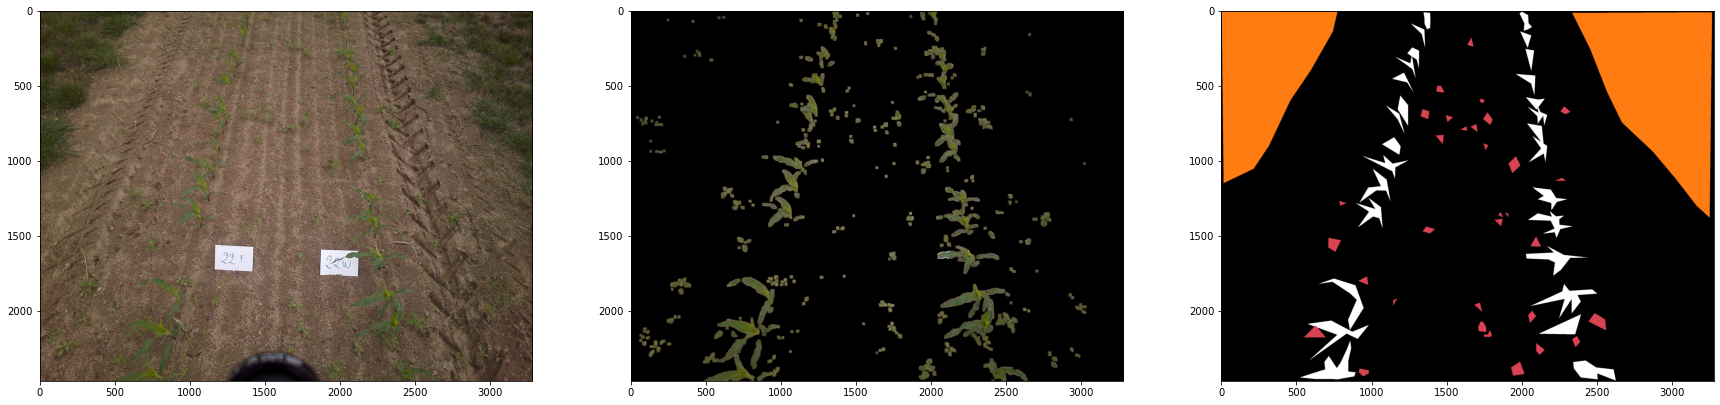

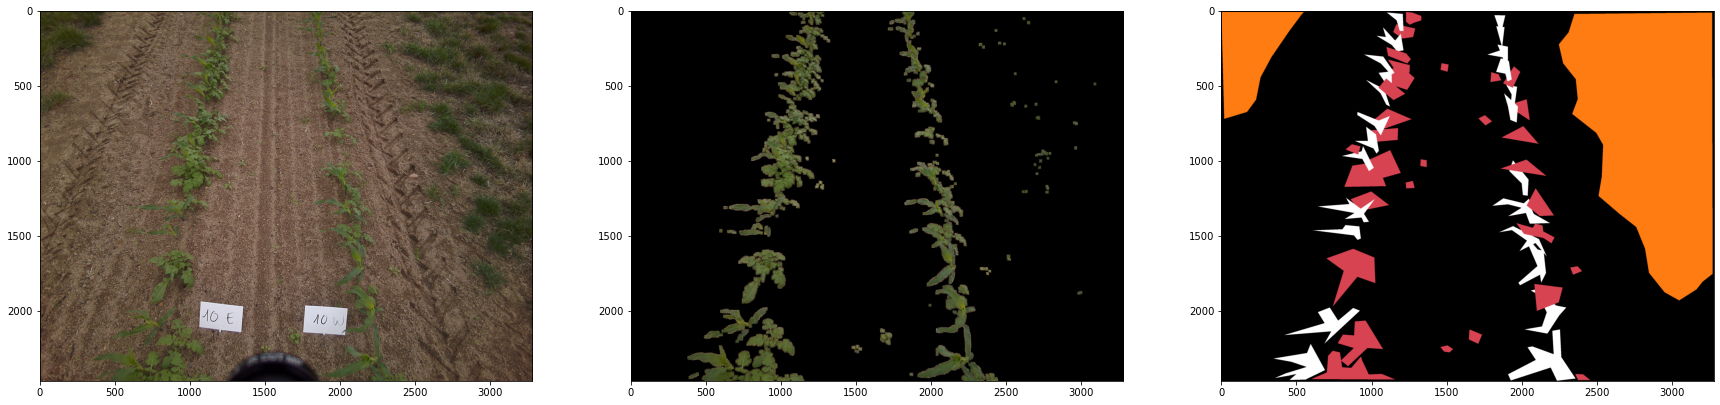

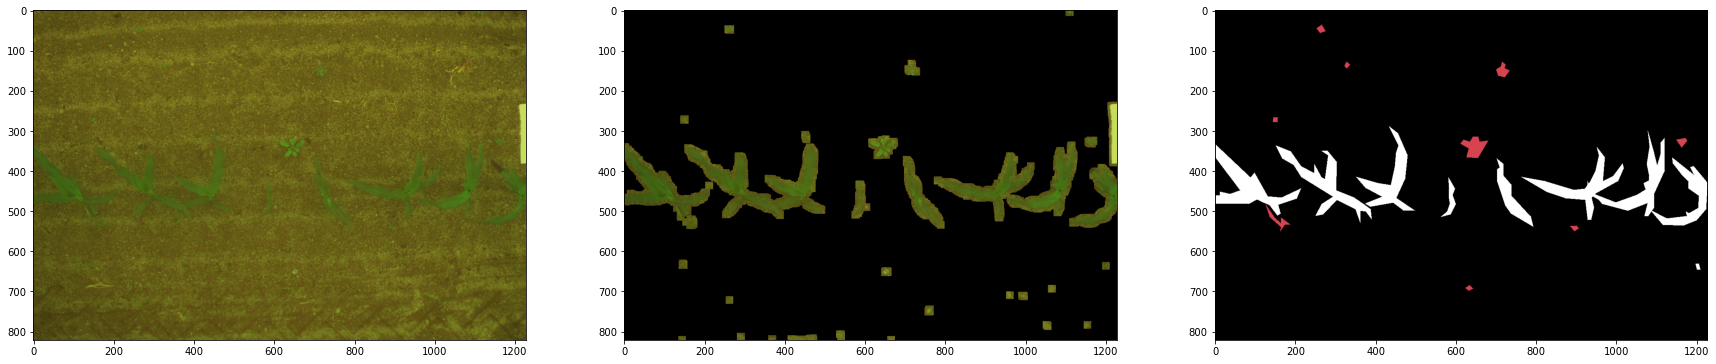

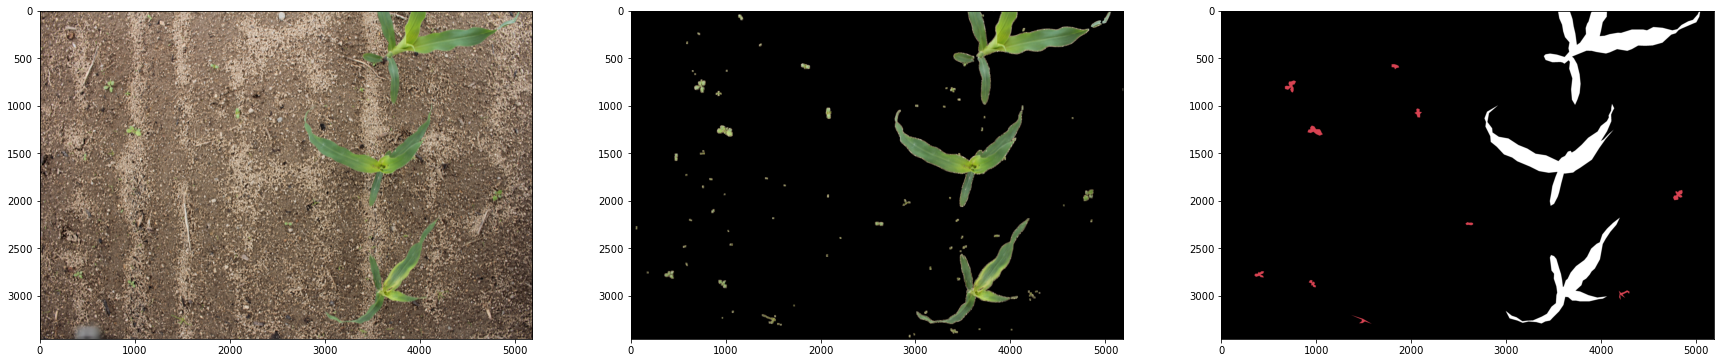

In [18]:
for i in np.random.choice(len(PATHS_TRAINING_IMAGES), 5):
    current_image = cv.imread(PATHS_TRAINING_IMAGES[i].as_posix(), cv.IMREAD_COLOR)
    current_image = cv.cvtColor(current_image, cv.COLOR_BGR2RGB)
    
    current_mask = cv.imread(PATHS_TRAINING_MASKS[i].as_posix(), cv.IMREAD_COLOR)
    current_mask = cv.cvtColor(current_mask, cv.COLOR_BGR2RGB)
    
    show(current_image, mask_image(current_image), current_mask)

## Sources
- [cambridge in colour](https://www.cambridgeincolour.com/tutorials/histograms1.htm)